In [1]:
#import
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import reuters
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

# --- 1. word index -> transformation 
word_index = reuters.get_word_index()
index_to_word = {v + 3: k for k, v in word_index.items()} #index_to_word dictionary missing the keys 0, 1, and 2 to add special tokens
for index, token in enumerate(("<pad>", "<sos>", "<unk>")): #generates index & item values (or token) pairs (ex: (0, '<pad>'), (1, '<sos>'), (2, '<unk>'))
    index_to_word[index] = token #index & item values (or token) added to index_to_word dictionary

# Replacing the loop above with these three lines is actually possible bruh
# index_to_word[0] = "<pad>"
# index_to_word[1] = "<sos>"
# index_to_word[2] = "<unk>"

def decode_texts(sequences):
    """정수 시퀀스 리스트를 텍스트 리스트로 변환"""
    return [' '.join([index_to_word.get(i, '<unk>') for i in seq]) for seq in sequences]
#this function takes in a list of sequences (lists of integers) and returns a list of strings, 
#where each string is the decoded text corresponding to the integer sequence.
#for example, if the input is [[1, 2, 3], [4, 5]], it will return ['<sos> <unk> word3', 'word4 word5'] assuming the index_to_word mapping.

#experiment setups
vocab_sizes = [10000, 20000, 30000] 
ml_models = {
    'MultinomialNB': MultinomialNB(),
    'ComplementNB': ComplementNB(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'LinearSVC (SVM)': LinearSVC(max_iter=1000, dual=False), 
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}
#ml_models dictionary => instances of various machine learning models in the dictionary; u can just use for loop to access each model and test them
#max_iter=1000 is set for Logistic Regression and LinearSVC to ensure convergence during training. (basically maximum repeatition; if not converged within this, it stops)
#random_state=42 is set for DecisionTree, RandomForest, and GradientBoosting to ensure reproducibility of results.
#dual=False in LinearSVC is set when the number of samples is greater than the number of features, which is often the case in text classification tasks.
#use dual=True when the number of features is greater than the number of samples.
#for MultinomialNB and ComplementNB, no additional parameters are set, so default values are used. (like alpha=1.0 fit prior=True etc)
#no optimization is necessary for these models (MultinomialNB and ComplementNB) as they calculate probability once statistically; results are always the same given the same data



# VotingClassifier is an ensemble model that combines multiple classifiers to improve performance.
# Here, we create a VotingClassifier that combines Logistic Regression, Complement Naive Bayes, and Gradient Boosting Classifier.
lr_model = LogisticRegression(max_iter=1000)
cnb_model = ComplementNB()
gbt_model = GradientBoostingClassifier(random_state=42)
ml_models['Voting'] = VotingClassifier( #adding VotingClassifier to ml_models dictionary
    estimators=[
        ('lr', lr_model),
        ('cnb', cnb_model),
        ('gbt', gbt_model)
    ],
    voting='soft' #soft voting means it uses predicted probabilities to make final predictions (ex. model a = 0.7, model b = 0.6 => final = 0.65)
)

results = [] #list for storing results; has to be defined BEFORE the experiment loop begins

#experiment loop
for num_words in vocab_sizes: #vocab_sizes = [3000, 5000, 8000] so 1st run with 3000 2nd 5000 3rd 8000
    print(f"\n--- Testing Vocabulary Size: {num_words} ---")
    
    # 1. 데이터 로드
    (x_train_num, y_train), (x_test_num, y_test) = reuters.load_data(
        num_words=num_words, test_split=0.2
    ) # loading reuters dataset with specified vocabulary size and 20% test split (3000, 5000, or 8000 most frequent words)
    
    # 2. decoding integer sequences to texts
    x_train_text = decode_texts(x_train_num) #decoding training data => necessary coz scikit-learn models (like CountVectorizer) expect text input
    x_test_text = decode_texts(x_test_num) #decoding test data
    
    # 3. TF-IDF vectorization
    vectorizer = CountVectorizer() #tokenizes text & counts word occurrences (creates DTM)
    x_train_dtm = vectorizer.fit_transform(x_train_text) 
    #reads all of training texts to build vocabulary (list of all unique words it finds). 
    #Then, it assigns a unique column index to each word (the = 50, article =234, etc.)
    x_test_dtm = vectorizer.transform(x_test_text)
    #converts each document string into a numerical row
    #Contains raw counts of how many times each word from the vocabulary appeared in that document
    #only uses vocab learned from the training data (no fitting here)
    #Result: x_train_dtm and x_test_dtm are sparse matrices representing the document(rows) -term(columns) matrices for training and test data respectively.
    
    tfidf_transformer = TfidfTransformer() #converts DTM to TF-IDF representation
    x_train_tfidf = tfidf_transformer.fit_transform(x_train_dtm)
    #calculates the IDF values for each word in the training data and then uses these IDF scores to convert the raw counts in x_train_dtm to TF-IDF scores.
    #the new score for a word is (its count in the document) x (its learned IDF scores)
    x_test_tfidf = tfidf_transformer.transform(x_test_dtm)
    #apply the same IDF weights learned from fit_transform on training data to the test data
    #apply the same importance scaling to the test data based on the training data statistics.
    
    actual_vocab_size = x_train_tfidf.shape[1]
    #this is a 2D matrix with rows (no of doc) and columns (no of unique words in the vocab)
    #.shape returns a pair of numbers: (num_rows, num_columns).
    #.shape[1] selects the second number, which is the total number of columns. => basically checks the number of unique words in the vocab after vectorization
    print(f"Actual vocabulary size found: {actual_vocab_size}")
    
    #model training and evaluation
    for name, model in ml_models.items(): #name = dictionary key ; model = dictionary value (the actual model instance)
        print(f"Training {name}...") #just for verification as to which model it is that is being trained
        model.fit(x_train_tfidf, y_train) # training the model on the TF-IDF transformed training data
        preds = model.predict(x_test_tfidf) # making predictions on the TF-IDF transformed test data
        
        acc = accuracy_score(y_test, preds) #calculating accuracy by comparing true labels (y_test) with predicted labels (preds)
        f1 = f1_score(y_test, preds, average='weighted') #calculating weighted F1-score (considers class imbalance by weighting each class's F1-score by its support)
        
        results.append({ #storing results in the results list defined earlier
            'num_words_setting': num_words if num_words else 'All', #storing the vocab size setting used (if num_words is None, it means all words were used)
            'model': name, #storing the model name
            'vocab_size_actual': actual_vocab_size, #storing the actual vocab size found after vectorization
            'accuracy': acc, #storing the accuracy score
            'f1_score': f1 #storing the F1-score
        })

# results
df_results = pd.DataFrame(results) #converting results list of dictionaries into a pandas DataFrame for easier analysis and visualization
print("\nML Results")
print(df_results.sort_values(by='f1_score', ascending=False)) #displaying the results sorted by F1-score in descending order

# best num_words setting
best_setting = df_results.loc[df_results['f1_score'].idxmax()] #idxmax() returns the index of the row with the highest F1-score
optimal_num_words = best_setting['num_words_setting'] #extracting the num_words setting corresponding to the best F1-score
if optimal_num_words == 'All': # not used
    optimal_num_words = None # not used 
print(f"\nOptimal setting: {best_setting['model']} with num_words={optimal_num_words}") #displaying the optimal model and its num_words setting


--- Testing Vocabulary Size: 10000 ---
Actual vocabulary size found: 9670
Training MultinomialNB...
Training ComplementNB...
Training LogisticRegression...
Training LinearSVC (SVM)...
Training DecisionTree...
Training RandomForest...
Training GradientBoosting...
Training Voting...

--- Testing Vocabulary Size: 20000 ---
Actual vocabulary size found: 18479
Training MultinomialNB...
Training ComplementNB...
Training LogisticRegression...
Training LinearSVC (SVM)...
Training DecisionTree...
Training RandomForest...
Training GradientBoosting...
Training Voting...

--- Testing Vocabulary Size: 30000 ---
Actual vocabulary size found: 25797
Training MultinomialNB...
Training ComplementNB...
Training LogisticRegression...
Training LinearSVC (SVM)...
Training DecisionTree...
Training RandomForest...
Training GradientBoosting...
Training Voting...

ML Results
    num_words_setting               model  vocab_size_actual  accuracy  \
3               10000     LinearSVC (SVM)               9670  0


--- Generating Visual Aids ---
Saved accuracy plot to 'model_comparison_accuracy.png'
Saved F1-score plot

Done.


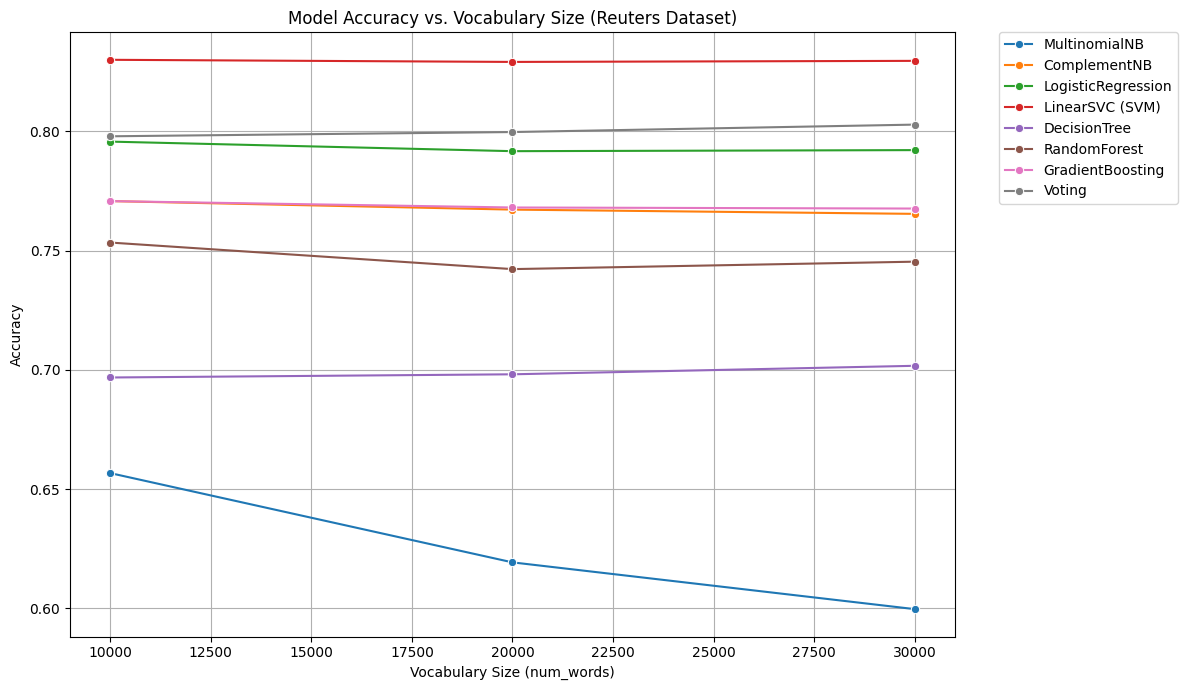

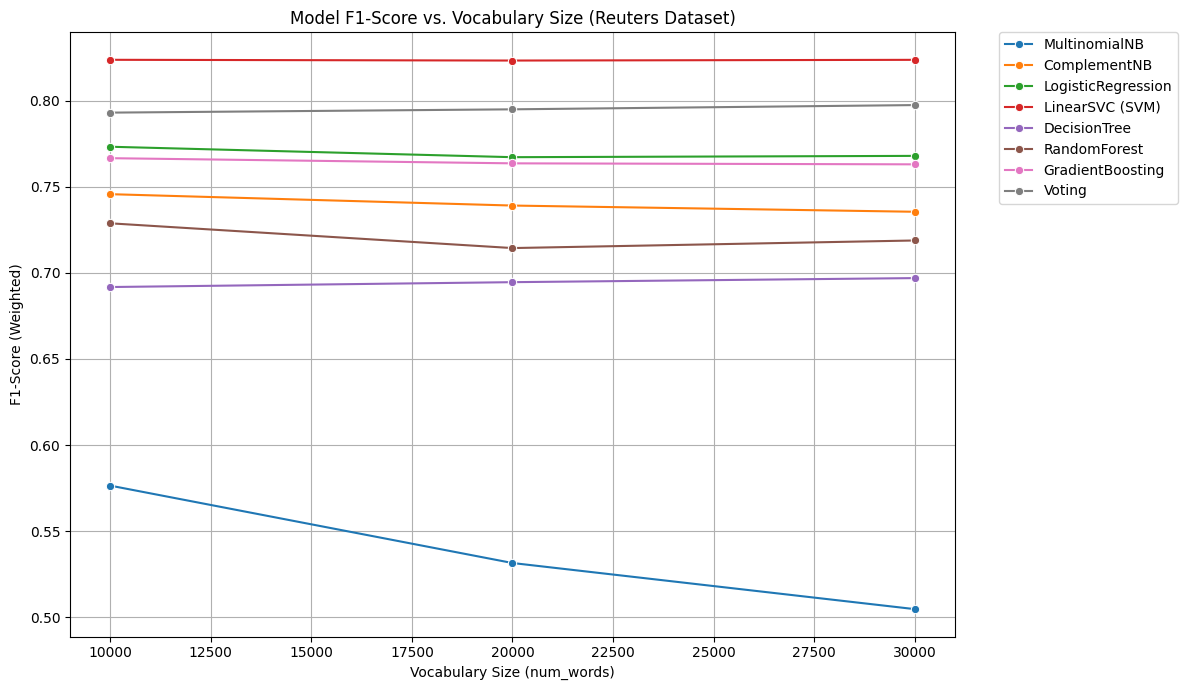

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


=
print("\n--- Generating Visual Aids ---")

#Accuracy Plot
plt.figure(figsize=(12, 7))
sns.lineplot(
    data=df_results, 
    x='num_words_setting', 
    y='accuracy', 
    hue='model', 
    marker='o'
)
plt.title('Model Accuracy vs. Vocabulary Size (Reuters Dataset)')
plt.xlabel('Vocabulary Size (num_words)')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
plt.savefig('model_comparison_accuracy.png')
print("Saved accuracy plot to 'model_comparison_accuracy.png'")

#F1-Score Plot
plt.figure(figsize=(12, 7))
sns.lineplot(
    data=df_results, 
    x='num_words_setting', 
    y='f1_score', 
    hue='model', 
    marker='o'
)
plt.title('Model F1-Score vs. Vocabulary Size (Reuters Dataset)')
plt.xlabel('Vocabulary Size (num_words)')
plt.ylabel('F1-Score (Weighted)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
plt.savefig('model_comparison_f1_score.png')
print("Saved F1-score plot")

print("\nDone.")


--- Testing Vocabulary Size: 10000 ---
Actual vocabulary size found (for TF-IDF): 9670
Training 1D CNN (Vocab Size: 10000)...
CNN Test Accuracy: 0.6625, F1-Score: 0.6570

--- Testing Vocabulary Size: 20000 ---
Actual vocabulary size found (for TF-IDF): 18479
Training 1D CNN (Vocab Size: 20000)...
CNN Test Accuracy: 0.6585, F1-Score: 0.6553

--- Testing Vocabulary Size: 30000 ---
Actual vocabulary size found (for TF-IDF): 25797
Training 1D CNN (Vocab Size: 30000)...
CNN Test Accuracy: 0.6336, F1-Score: 0.6265

--- ML & DL Model Comparison Results ---
   num_words_setting   model  vocab_size_actual  accuracy  f1_score
0              10000  1D CNN              10000  0.662511  0.656975
1              20000  1D CNN              20000  0.658504  0.655269
2              30000  1D CNN              30000  0.633571  0.626483

--- Generating Visual Aids ---
Saved accuracy plot to 'model_comparison_accuracy.png'
Saved F1-score plot to 'model_comparison_f1_score.png'

Done.


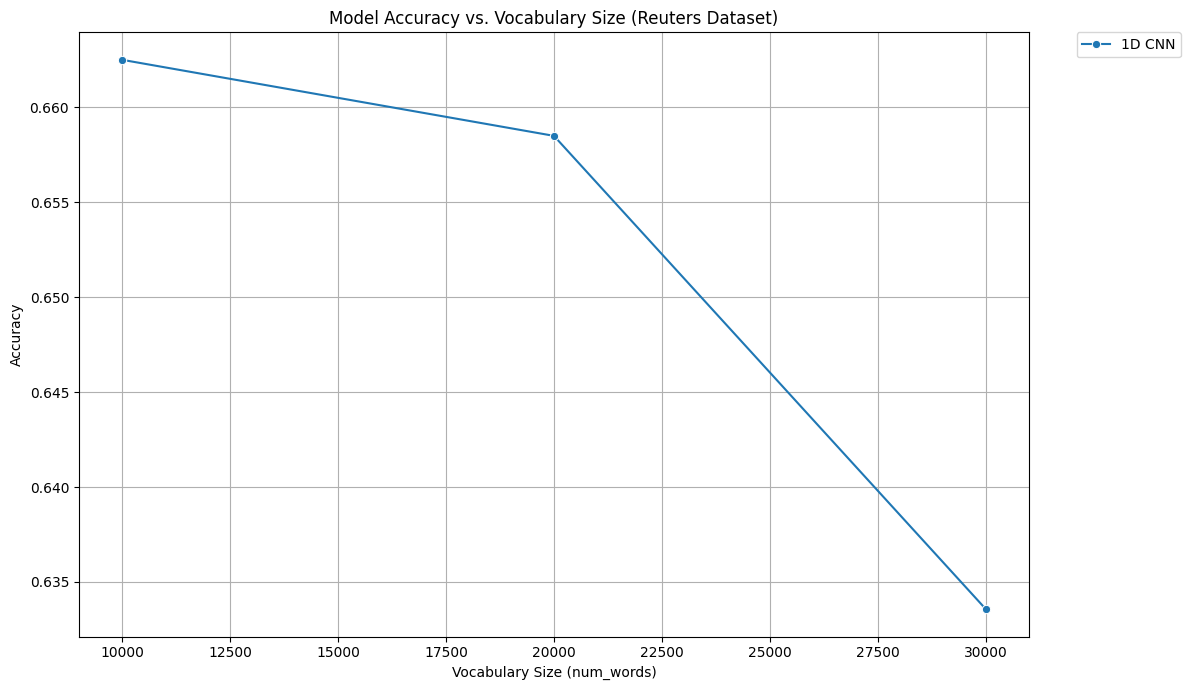

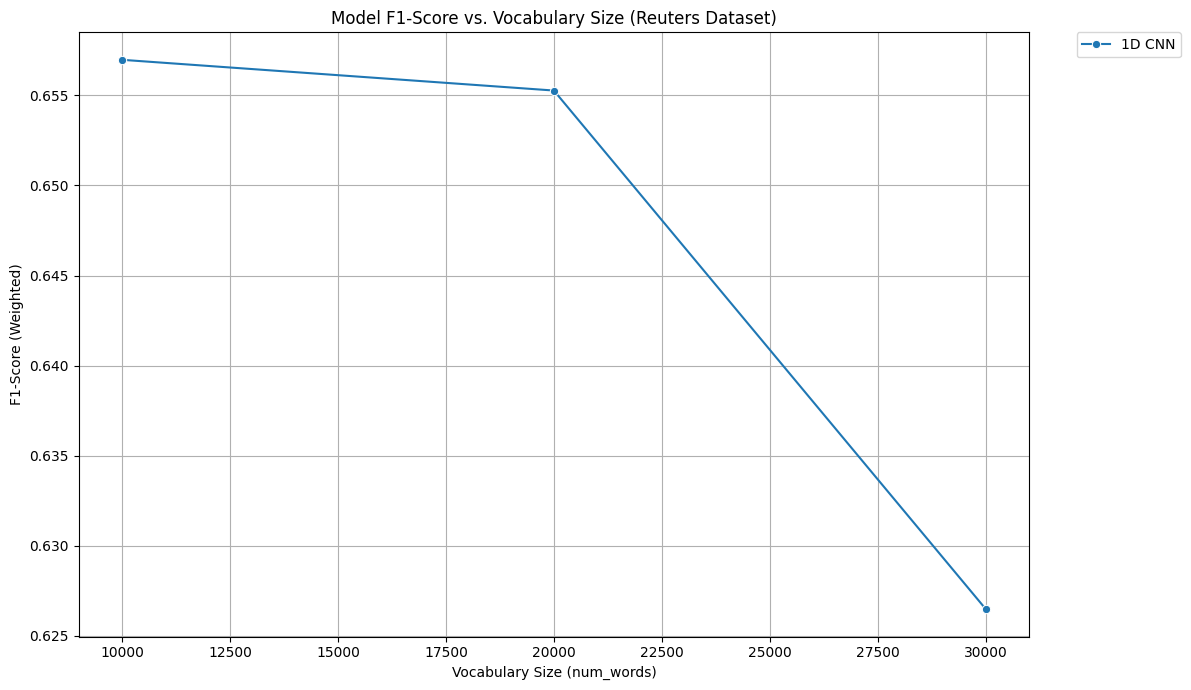

In [ ]:
#libraries
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import reuters
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import time

import matplotlib.pyplot as plt
import seaborn as sns


word_index = reuters.get_word_index()
index_to_word = {v + 3: k for k, v in word_index.items()}
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index] = token

def decode_texts(sequences):
    """Converts a list of integer sequences back into text."""
    return [' '.join([index_to_word.get(i, '<unk>') for i in seq]) for seq in sequences]


class Model_1D_CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, out_channels, output_dim, pad_idx):
        super(Model_1D_CNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
        # Conv1d expects (batch_size, in_channels, seq_len)
        # permute embedding output to (batch_size, embedding_dim, seq_len)
        self.conv1 = nn.Conv1d(embedding_dim, out_channels, kernel_size=7)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=7)
        self.pool = nn.MaxPool1d(5)
        self.global_max_pooling = nn.AdaptiveMaxPool1d(1)
        
        self.fc1 = nn.Linear(out_channels, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, output_dim) 
        
    def forward(self, x):
        # x: (batch_size, seq_len)
        x = self.embedding(x)
        # x: (batch_size, seq_len, embedding_dim)
        
        # permute to (batch_size, embedding_dim, seq_len)
        x = x.permute(0, 2, 1)
        
        x = self.conv1(x) # (batch_size, out_channels, seq_len')
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x) # (batch_size, out_channels, seq_len'')
        x = self.relu(x)
        
        x = self.global_max_pooling(x) # (batch_size, out_channels, 1)
        
        x = x.view(x.size(0), -1) # (batch_size, out_channels)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x # (batch_size, output_dim)


def train_and_evaluate_cnn(num_words, num_classes, x_train_num, y_train, x_test_num, y_test):
    print(f"Training 1D CNN (Vocab Size: {num_words})...")
    
    #Hyperparameters 
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    EMBEDDING_DIM = 100 # You can adjust this
    CNN_OUT_CHANNELS = 16
    OUTPUT_DIM = num_classes
    NUM_EPOCHS = 30 
    LEARNING_RATE = 1e-3
    BATCH_SIZE = 64
    PAD_INDEX = 0
    
    # Data Preprocessing (Padding)
    # Calculate maxlen based on train set (using 95th percentile for robustness)
    lengths = [len(x) for x in x_train_num]
    maxlen = int(np.percentile(lengths, 95)) 
    
    X_train_tensors = [torch.tensor(seq[:maxlen]) for seq in x_train_num]
    X_test_tensors = [torch.tensor(seq[:maxlen]) for seq in x_test_num]
    
    X_train_pad = pad_sequence(X_train_tensors, batch_first=True, padding_value=PAD_INDEX)
    X_test_pad = pad_sequence(X_test_tensors, batch_first=True, padding_value=PAD_INDEX)
    
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    
    train_dataset = TensorDataset(X_train_pad, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    test_dataset = TensorDataset(X_test_pad, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model_1D_CNN(
        vocab_size=num_words, 
        embedding_dim=EMBEDDING_DIM, 
        out_channels=CNN_OUT_CHANNELS, 
        output_dim=OUTPUT_DIM,
        pad_idx=PAD_INDEX
    ).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        epoch_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            preds = outputs.argmax(dim=1) 
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    print(f"CNN Test Accuracy: {acc:.4f}, F1-Score: {f1:.4f}")
    return acc, f1



vocab_sizes = [10000, 20000, 30000] 

results = [] 

for num_words in vocab_sizes:
    print(f"\n--- Testing Vocabulary Size: {num_words} ---")
    
    # 1. Load data (for both sklearn and CNN)
    (x_train_num, y_train), (x_test_num, y_test) = reuters.load_data(
        num_words=num_words, test_split=0.2
    )
    num_classes = int(np.max(y_train) + 1)
    
    # 2. Decode texts (for sklearn TF-IDF)
    x_train_text = decode_texts(x_train_num)
    x_test_text = decode_texts(x_test_num)
    
    # 3. TF-IDF vectorization (for sklearn)
    vectorizer = CountVectorizer()
    x_train_dtm = vectorizer.fit_transform(x_train_text)
    x_test_dtm = vectorizer.transform(x_test_text)
    
    tfidf_transformer = TfidfTransformer()
    x_train_tfidf = tfidf_transformer.fit_transform(x_train_dtm)
    x_test_tfidf = tfidf_transformer.transform(x_test_dtm)
    
    actual_vocab_size = x_train_tfidf.shape[1]
    print(f"Actual vocabulary size found (for TF-IDF): {actual_vocab_size}")
    
        
 
    cnn_acc, cnn_f1 = train_and_evaluate_cnn(
        num_words=num_words, # Use the limited vocab size
        num_classes=num_classes,
        x_train_num=x_train_num, y_train=y_train,
        x_test_num=x_test_num, y_test=y_test
    )
    
    results.append({
        'num_words_setting': num_words,
        'model': '1D CNN',
        'vocab_size_actual': num_words, # CNN embedding layer uses this
        'accuracy': cnn_acc,
        'f1_score': cnn_f1
    })


df_results = pd.DataFrame(results)
print("\n--- ML & DL Model Comparison Results ---")
print(df_results.sort_values(by='f1_score', ascending=False))


print("\n--- Generating Visual Aids ---")

#Accuracy Plot 
plt.figure(figsize=(12, 7))
sns.lineplot(
    data=df_results, 
    x='num_words_setting', 
    y='accuracy', 
    hue='model', 
    marker='o'
)
plt.title('Model Accuracy vs. Vocabulary Size (Reuters Dataset)')
plt.xlabel('Vocabulary Size (num_words)')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
plt.savefig('model_comparison_accuracy.png')
print("Saved accuracy plot to 'model_comparison_accuracy.png'")

#F1-Score Plot
plt.figure(figsize=(12, 7))
sns.lineplot(
    data=df_results, 
    x='num_words_setting', 
    y='f1_score', 
    hue='model', 
    marker='o'
)
plt.title('Model F1-Score vs. Vocabulary Size (Reuters Dataset)')
plt.xlabel('Vocabulary Size (num_words)')
plt.ylabel('F1-Score (Weighted)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
plt.savefig('model_comparison_f1_score.png')
print("Saved F1-score plot to 'model_comparison_f1_score.png'")

print("\nDone.")

회고

전체적으로 봤을때 SVM이 성능적으로 여타 모델 (1D CNN 포함)들을 압도하는 모습을 보여줬다. F1-score 상위 1-3등이 Vocab_size와 관련없이 전부 SVM이었다

개인적으로 SVM이 최상위권에 들꺼라 예상은 했지만 왜 그런지는 분석이 필요하다. <br>
또한, 왜 1D CNN은 이렇게 처참한 성능을 보이는지도 의문점이다. <br>
마지막으로 Voting이 성능이 좋을꺼라 예상은 했지만 그 바로 아래에 Logistic Regression이 바짝 따라오는것은 예상 밖이었다.


1. 왜 svm이 최고 성능을 보였을까?

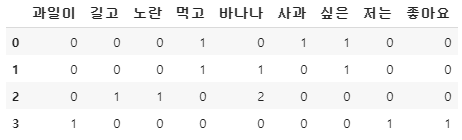 <br>

서포트 벡터 머신 용어:<br>

두 클래스의 데이터를 최적으로 구분하는 선을 결정 경계라고 한다. <br>
이 결정 경계와 가장 가까운 데이터 포인트들을 서포트 벡터라고 부른다. 이떄 서포트 벡터 사이의 거리를 마진이라 한다. <br>

간략히 말해서 서포트 벡터 머신은 이 마진을 최대화 할 수 있는 결정경계를 찾는 알고리즘으로 그저 분류만 하면 된다가 아니라 이 마진을 최대화 하는 과정을 통해서 가장 안정적으로 분류를 하는 지점에 결정 경계가
만들어지는것이다. <br>이러한 특징으로 인해서 테스트 성능이 잘 나오는걸로 사료된다. 
 
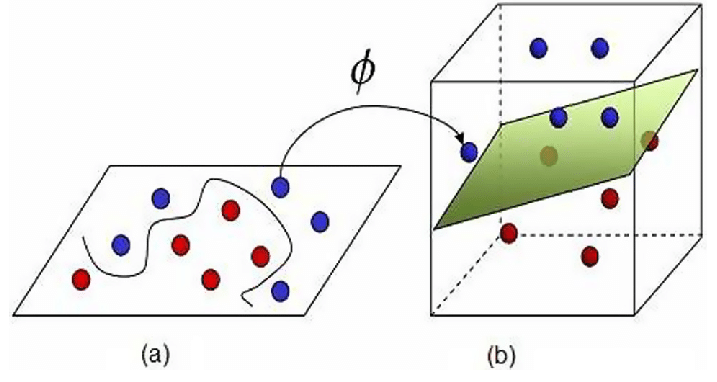 <br>
고차원의 저주가 오히려 축복으로?<br> 

TF-IDF는 기본적으로 고차원이면서 희소한 데이터들의 모음이다. <br>
2차원에서는 분류 불가능한걸 3차원으로 끌어올리면 그림과 같이 깔끔하게 분류하는게 가능하며 차원이 늘어날수록 이와같이 데이터를 구분하는 가장 최적의 결정경계를 찾을수 있는 가능성이 매우 올라간다.<br>
그외에도 계산 효율성이 있긴합니다 (가중치 패러미터 * 특징이라 그게 대부분 0이면 실수인 값들만 계산하면 되죠?).<br>
마지막으로 기본적으로 정규화가 적용되 있습니다 그래서 자동으로 중요하지 않은 단어들에는 가중치를 낮추고 중요한 단어들에만 높은 가중치를 허락합니다 (과적합 방지)

2. 1D CNN은 왜 이럼 처참한 결과가 나왔을까?

전반적인 주제를 맞추는게 이번 프로젝트 과제인데 문제는 CNN은 여기서 단어 7개가 연속으로 등장하는 국소적인 패턴을 학습한다. <br>
즉, 핵심 단어가 어디에 있는지가 아닌 존재한다는거 자체가 중요한거라 국소적인 패턴이 도움이 안된것이다. <br>

3. Logistic Regression의 예상밖의 선전. 왜일까? <br>

LR도 기본적으로 선형모델이라 SVM과 마찬가지로 고차원이 축복이 됩니다. 희소한 고차원 행렬 데이터에서 토픽을 잘 구분하는 경계선을 찾는건 저차원에서 찾는것보다 훨씬 수월합니다.
마찬가지로 비슷한 계산 효율성과 정규화의 적용으로 과적합 방지를 함을 통해서 일반화 성능이 높을것이라 예상 가능합니다 
